# Bimodal distribution with correlations
### Notebook

--- 

In [1]:
using Revise, DrWatson
@quickactivate

In [2]:
using main
using BlockDiagonals, LinearAlgebra, Pipe, Plots, ProgressMeter
using Distributions, MCMCChains, NNlib, Random, StatsBase, Zygote, ForwardDiff

gr(fmt=:png, levels=5, lw=0.1, msa=0.1, msw=0.5, ma=0.2, msc=:firebrick1, legend=:topright)
ProgressMeter.ijulia_behavior(:clear);

In [3]:
function generate_model(; m = 2.0, d = 10, s=0.75, method=:reverse)
    R = prod(
        [
        BlockDiagonal(
            [diagm(ones(2j)),
            [0.0 -1.0; 1.0 0.0],
            diagm(ones(d - 2j - 2))]
        ) for j in 0:round(Int, d / 2 - 1)
    ]
    )
    Σ₁ = [s^abs(i - j) for i in 1:d, j in 1:d]
    Σ₂ = R * Σ₁ * R'
    μ = [-m .* ones(d), m .* ones(d)]
    Σ = [Σ₁, Σ₂]

    ξ = MixtureModel(
        [MvNormal(x, y) for (x, y) in zip(μ, Σ)]
    )
    S = [inv(s) for s in Σ]
    
    f(x) = [-dot(x-m, s, x-m) for (m, s) in zip(μ, S)] .|> exp |> sum
    U(x) = -logsumexp([-dot(x-m, s, x-m) for (m, s) in zip(μ, S)])
    DU(x) = Zygote.gradient(U, x)[1]
    
    return Model(ξ=ξ, f=f, U=U, dU=DU)
end

generate_model (generic function with 1 method)

#### Wasserstein metric and Plot functions


In [4]:
function bures(m1, m2, s1, s2)
    a = norm(m1 - m2)^2
    b = tr(sqrt(sqrt(s1) * s2 * sqrt(s1)))
    c = tr(s1) + tr(s2) - 2 * b
    return sqrt(a + c)
end

function w2(X)
    if typeof(X) <: Tuple
        Y = rand(model.ξ, size(X[1], 1))' |> Matrix
        Z = X[1]
        return bures(mean(Z), mean(Y), cov(Z), cov(Y))
    else
        Y = rand(model.ξ, size(X, 1))' |> Matrix
        return bures(mean(X), mean(Y), cov(X), cov(Y))
    end
end

w2 (generic function with 1 method)

In [5]:
function scatterplot(x; baseplt=plot(0,0,label=""), label="", kwargs...)
    if typeof(x) <: Tuple
        plt = plot(baseplt, x[1] |> m2t, c=:black, lw=0.1, la=0.25, label="")
        plt = scatter(plt, x[1] |> m2t, ms=exp.(2 .* standardize(UnitRangeTransform, x[2])), label=label, c=:orange; kwargs...)
    else
        plt = plot(baseplt, x |> m2t, c=:black, lw=0.1, la=0.25, label="")
        plt = scatter(plt, x |> m2t, c=:orange, label=label; kwargs...)
    end
    return plt
end

function acfplots(chains, names, lags=0:2:50; kwargs...)
    plt = plot(0, 0)
    for (x, n) in zip(chains, names)
        plt = plot(plt, mean(1 .* (autocor(x, lags=[lags...])[:, :]), dims=1)', label=n; kwargs...)
    end
    return plt
end

function scatterplots(xs, names; baseplt=plot(0,0,label=nothing), l=400, kwargs...)
    L = length(xs)
    ds = sample(1:size(xs[1], 2), 2, replace=false)
    plts = [scatter(baseplt, x[:, ds[1]], x[:, ds[2]], label=names[i]) for (x, i) in zip(xs, eachindex(xs))]
    plot(plts..., axes=false, ticks=false; kwargs...)
end

function traceplots(xs, names, args...; baseplt=plot(0,0,label=nothing), l=400, kwargs...)
    L = length(xs)
    ds = sample(1:size(xs[1], 2), 1, replace=false)
    plts = [plot( (typeof(x) <: Tuple ? x[1][:, ds[1]] : x[:, ds[1]]), label=names[i]; args...) for (x, i) in zip(xs, eachindex(xs))]
    plot(plts...; kwargs...)
end

function mean_ess(chains)
    return [ess_rhat(chn)[:, 2] |> mean for chn in chains]
end

mean_ess (generic function with 1 method)

<br><br><br>

---

# Example: $\mathbb R^{2}$

In [6]:
model = generate_model(d=2);

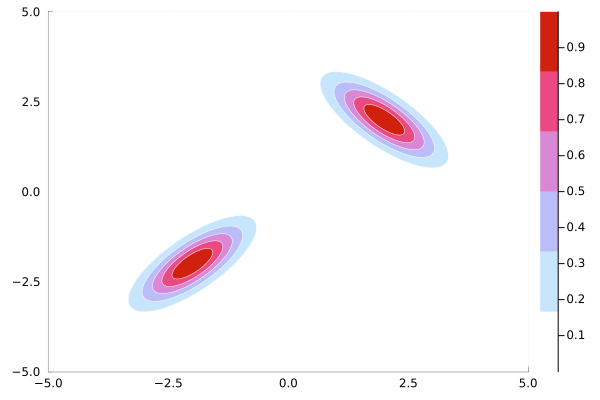

In [7]:
cls = palette(:linear_wcmr_100_45_c42_n256, 100, rev=false)
plt(; lim=(-5, 5)) = contourf(
    repeat([range(lim..., length=200)], 2)..., 
    (x, y) -> model.f([x; y]),
    c=cls
)
plt2 = plt()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
  HMC(0.5565515579415289, 18, Any[]):  0.7174565086982604


Acceptance Ratio = 0.7186
  8.299608 seconds (19.79 M allocations: 1.021 GiB, 3.50% gc time, 79.91% compilation time)


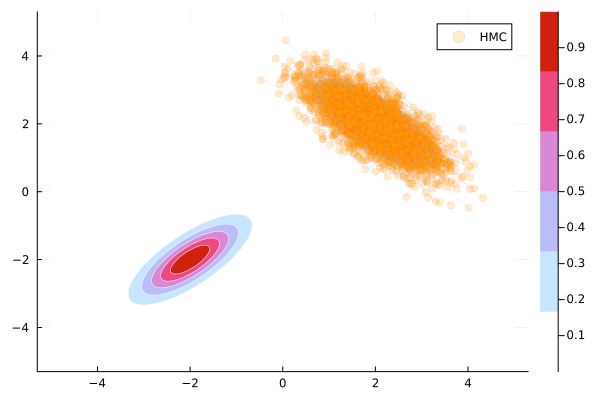

In [8]:
@time s1, a1 = mcmc(
    DualAverage(λ=10.0, δ=0.65),
    HMC(),
    model; n=5e3, n_burn=1e3
)
x_hmc = s1[a1, :]
chain_hmc = Chains(x_hmc)
plt2_hmc = scatterplot(x_hmc[:, 1:2], baseplt=plt(), label="HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
  RAHMC(0.262644954709178, 76, 0.49107956242434986, Any[]):  0.4923015396920616


Acceptance Ratio = 0.4915
 13.646824 seconds (46.90 M allocations: 2.338 GiB, 4.14% gc time, 6.39% compilation time)


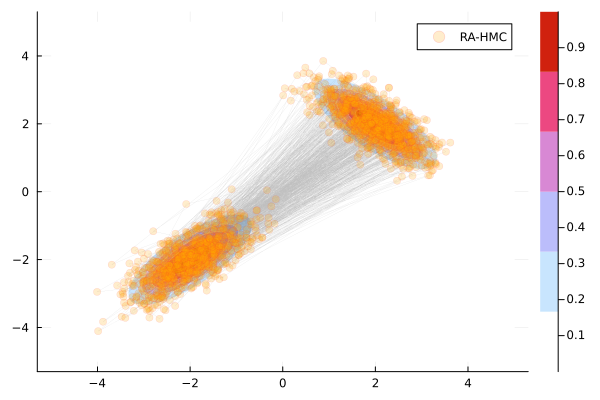

In [9]:
@time s2, a2 = mcmc(
    DualAverage(λ=20.0, δ=0.65),
    RAHMC(),
    model; n=5e3, n_burn=1e3
)
x_rahmc = s2[a2, :]
chain_rahmc = Chains(x_rahmc)
plt2_rahmc = scatterplot(x_rahmc[:, 1:2], baseplt=plt(), label="RA-HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(ZeroMeanIsoNormal(
dim: 2
μ: Zeros(2)
Σ: [2.25 0.0; 0.0 2.25]
)
, [0.6562070449834658, -0.5257418851091965], Any[]):       0.3191134810864856


Acceptance Ratio = 0.3153
  1.176734 seconds (2.70 M allocations: 153.376 MiB, 4.52% gc time, 87.09% compilation time)


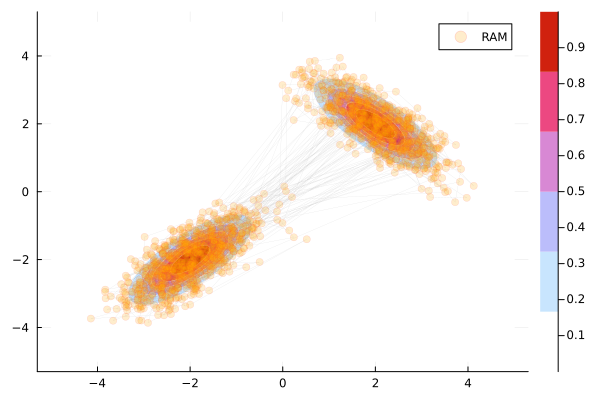

In [10]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 1.5), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_ram = s3[a3, :]
chain_ram = Chains(x_ram)
plt2_ram = scatterplot(x_ram[:, 1:2], baseplt=plt(), label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:43
  PEHMC:  0.9201451905626135


Acceptance Ratio = 0.8654
103.941565 seconds (534.48 M allocations: 30.404 GiB, 7.28% gc time, 23.57% compilation time)


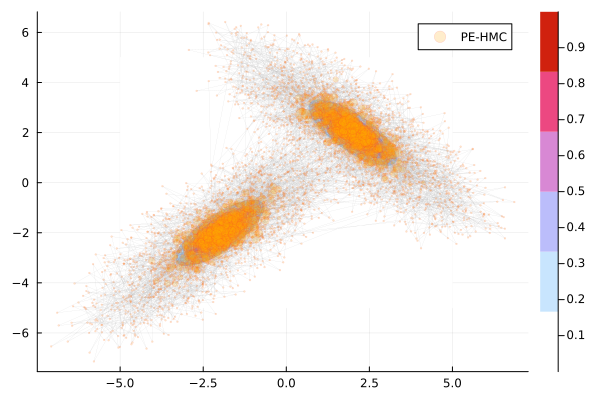

In [11]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.1, L=20, N=100),
    model; n=50, n_burn=500
)
x_pehmc, w_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_pehmc = Chains(x_pehmc)
plt2_pehmc = scatterplot((x_pehmc, w_pehmc), baseplt=plt(), label="PE-HMC")

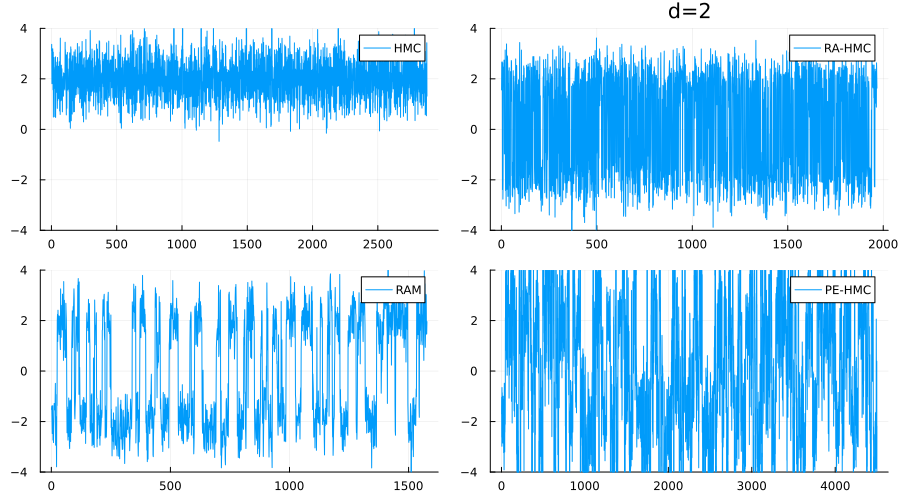

In [12]:
names = ("HMC", "RA-HMC", "RAM", "PE-HMC")
xs2d = [x_hmc, x_rahmc, x_ram, (x_pehmc, w_pehmc)]
chains2d = [chain_hmc, chain_rahmc, chain_ram, chain_pehmc];

plt2_tr = traceplots(xs2d, names, lw=1, layout=(2,2), ylim=(-4,4), l=100, size=(900, 500), title=["" "d=2" "" ""])

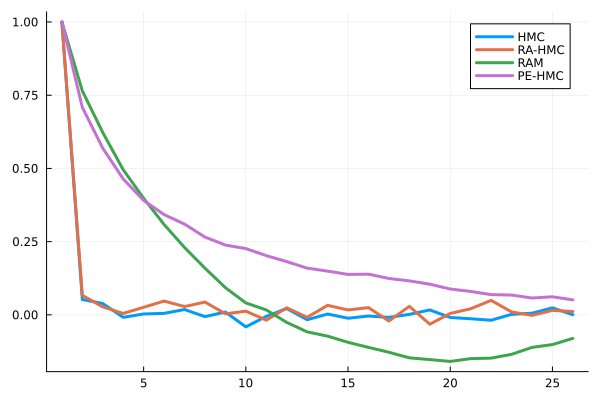

In [13]:
plt2_acf = acfplots(chains2d, names, lw=3)

In [14]:
mean_ess(chains2d)

4-element Vector{Float64}:
 2890.539983552882
 1401.3233282305496
  128.16159408192334
  207.59542732803223

In [15]:
w2.(xs2d)

4-element Vector{Float64}:
 3.334236564751826
 0.3926057612380762
 0.26409420123946453
 0.7146752279836102

<br><br><br>

---

# Example: $\mathbb R^{10}$

In [16]:
model = generate_model(d=10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
  HMC(0.31209556037460273, 32, Any[]):  0.8284343131373725


Acceptance Ratio = 0.8306
  6.172342 seconds (13.12 M allocations: 2.056 GiB, 16.56% gc time, 25.83% compilation time)


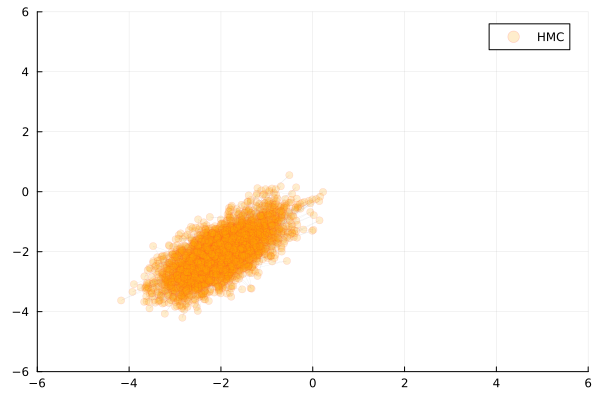

In [17]:
@time s1, a1 = mcmc(
    DualAverage(λ=10, δ=0.6),
    HMC(),
    model; n=5e3, n_burn=1e3
)
x_10_hmc = s1[a1, :]
chain_10_hmc = Chains(x_10_hmc)
plt10_hmc = scatterplot(x_10_hmc[:, 1:2], lim=(-6, 6), label="HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
  RAHMC(0.17334638858478005, 115, 0.31035976676993565, Any[]):  0.6574685062987402


Acceptance Ratio = 0.6626
 24.216206 seconds (54.95 M allocations: 11.274 GiB, 8.94% gc time)


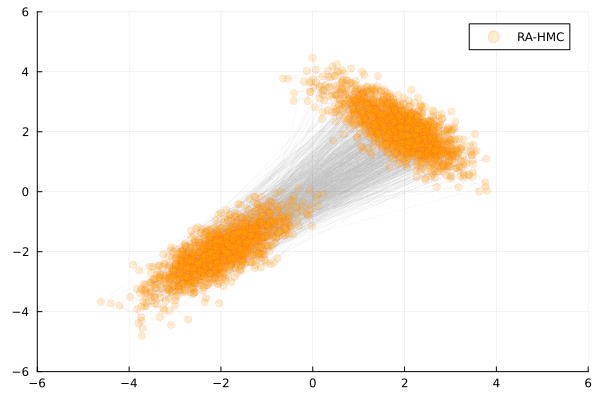

In [18]:
@time s2, a2 = mcmc(
    DualAverage(λ=20.0, δ=0.65),
    RAHMC(),
    model; n=5e3, n_burn=1e2
)
x_10_rahmc = s2[a2, :]
chain_10_rahmc = Chains(x_10_rahmc)
plt10_rahmc = scatterplot(x_10_rahmc[:, 1:2], lim=(-6, 6), label="RA-HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(ZeroMeanIsoNormal(
dim: 10
μ: Zeros(10)
Σ: [0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25]
)
, [-0.8217389943064359, 0.4585380384228288, 0.44619185184571397, -0.5322333496933032, -0.44934319245119764, 0.3487105645280863, -1.9083038763958828, 0.49130266500774794, 0.9287393129952212, -1.1671024788798658], Any[]):       0.11798033661056491


Acceptance Ratio = 0.1176
  0.204367 seconds (1.25 M allocations: 105.247 MiB, 12.62% gc time)


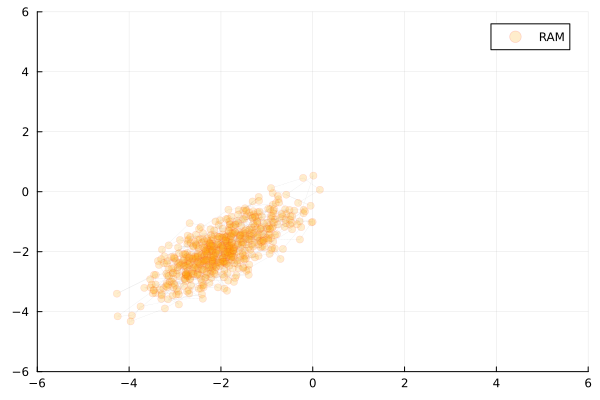

In [19]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 0.5), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_10_ram = s3[a3, :]
chain_10_ram = Chains(x_10_ram)
plt10_ram = scatterplot(x_10_ram[:, 1:2], lim=(-6, 6), label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
  PEHMC:  0.6357615894039735


Acceptance Ratio = 0.6154
 22.541499 seconds (103.60 M allocations: 10.224 GiB, 11.51% gc time)


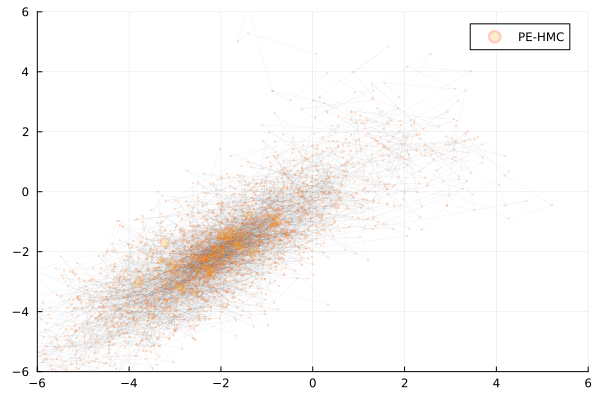

In [21]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.08, L=15, N=100),
    model; n=5e1, n_burn=1e2
)
x_10_pehmc, w_10_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_10_pehmc = Chains(x_10_pehmc)
plt10_pehmc = scatterplot((x_10_pehmc[:, 1:2], w_10_pehmc), label="PE-HMC", lim=(-6, 6))

In [22]:
xs10d = [x_10_hmc, x_10_rahmc, x_10_ram, (x_10_pehmc, w_10_pehmc)]
chains10d = [chain_10_hmc, chain_10_rahmc, chain_10_ram, chain_10_pehmc];

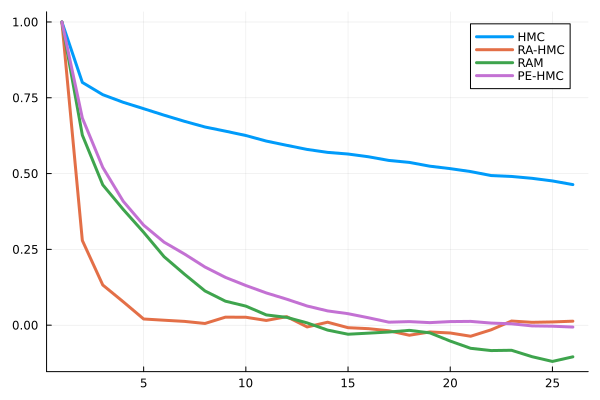

In [23]:
plt10_acf = acfplots(chains10d, names, lw=3)

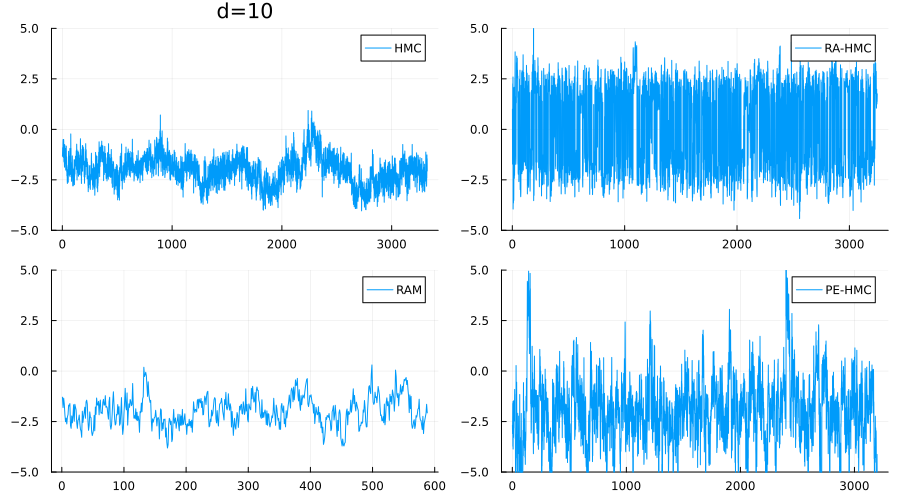

In [24]:
plt10_tr = traceplots(xs10d, names, lw=1, layout=(2,2), ylim=(-5,5), l=100, size=(900, 500), title=["d=$(model.d)" "" "" ""])

In [25]:
mean_ess(chains10d)

4-element Vector{Float64}:
  28.637197648620127
 777.279242709364
  46.16782942584697
 219.64520002176081

In [26]:
w2.(xs10d)

4-element Vector{Float64}:
 5.5531111942985225
 0.7739973533606673
 5.457369519464631
 3.789133115500021

<br><br><br>

---

# Example: $\mathbb R^{20}$

In [27]:
model = generate_model(d=20);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
  HMC(0.38045867928217164, 26, Any[]):  0.595880823835233


Acceptance Ratio = 0.5937
  8.069833 seconds (11.51 M allocations: 3.981 GiB, 11.83% gc time, 2.61% compilation time)


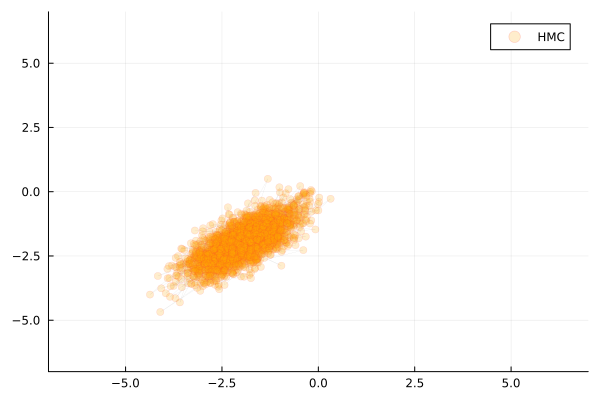

In [28]:
@time s1, a1 = mcmc(
    DualAverage(λ=10, δ=0.6),
    HMC(),
    model; n=5e3, n_burn=1e3
)
x_20_hmc = s1[a1, :]
chain_20_hmc = Chains(x_20_hmc)
plt20_hmc = scatterplot(x_20_hmc[:, 1:2], label="HMC", lim=(-7, 7))

Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
  RAHMC(0.15215185556430758, 263, 0.3156567673548658, Any[]):  0.6256748650269947


Acceptance Ratio = 0.6249
157.906089 seconds (226.69 M allocations: 81.925 GiB, 12.28% gc time)


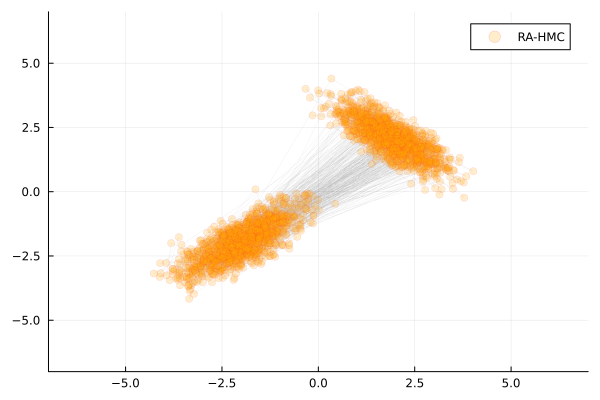

In [29]:
@time s2, a2 = mcmc(
    DualAverage(λ=40.0, δ=0.65),
    RAHMC(),
    model; n=5e3, n_burn=1e3
)
x_20_rahmc = s2[a2, :]
chain_20_rahmc = Chains(x_20_rahmc)
plt20_rahmc = scatterplot(x_20_rahmc[:, 1:2], label="RA-HMC", lim=(-7, 7))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(ZeroMeanIsoNormal(
dim: 20
μ: Zeros(20)
Σ: [0.0144 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0144 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0144 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0144 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

Acceptance Ratio = 0.437
  0.194752 seconds (875.20 k allocations: 103.047 MiB, 15.41% gc time)


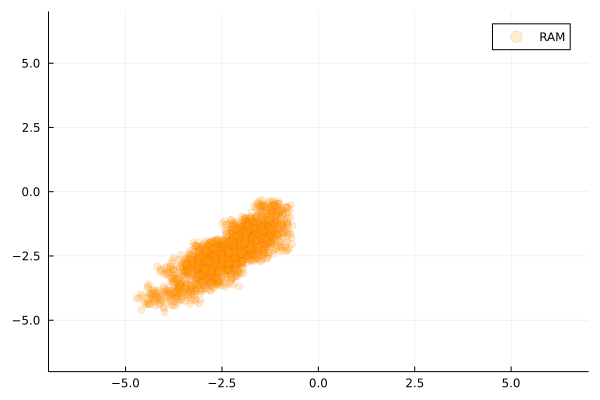

In [31]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 0.12), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_20_ram = s3[a3, :]
chain_20_ram = Chains(x_20_ram)
plt20_ram = scatterplot(x_20_ram[:, 1:2], lim=(-7, 7), label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
  PEHMC:  0.4900662251655629


Acceptance Ratio = 0.6346
 70.629047 seconds (269.07 M allocations: 54.190 GiB, 12.08% gc time)


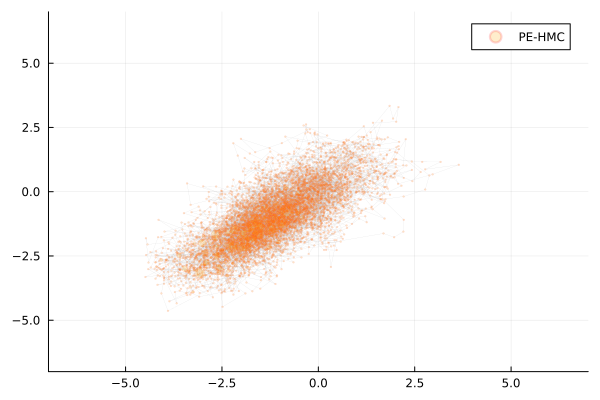

In [32]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.02, L=20, N=200),
    model; n=5e1, n_burn=1e2
)
x_20_pehmc, w_20_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_20_pehmc = Chains(x_20_pehmc)
plt20_pehmc = scatterplot((x_20_pehmc[:, 1:2], w_20_pehmc), label="PE-HMC", lim=(-7, 7))

In [33]:
xs20d = [x_20_hmc, x_20_rahmc, x_20_ram, (x_20_pehmc, w_20_pehmc)]
chains20d = [chain_20_hmc, chain_20_rahmc, chain_20_ram, chain_20_pehmc];

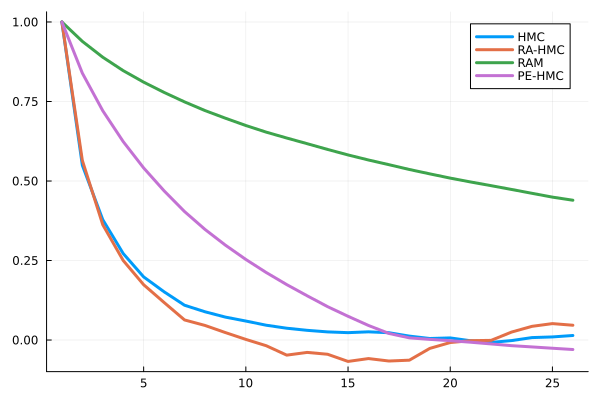

In [34]:
plt20_acf = acfplots(chains20d, names, lw=3)

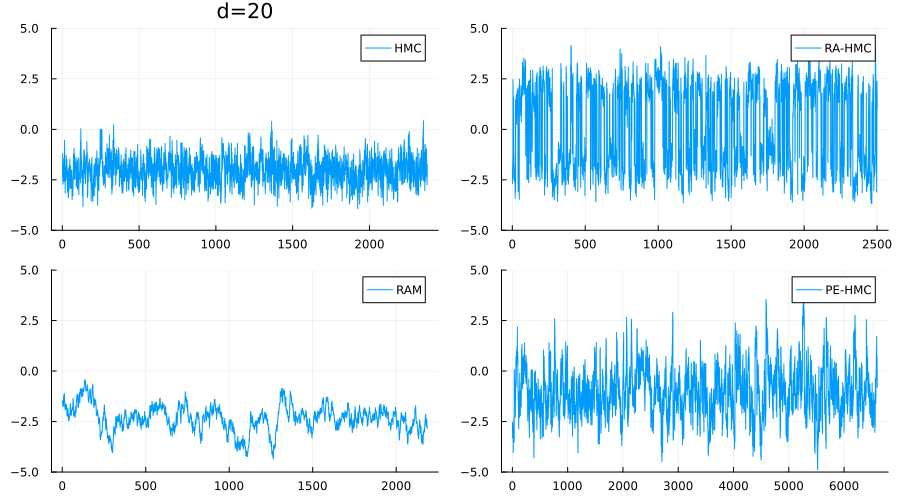

In [35]:
plt20_tr = traceplots(xs20d, names, lw=1, layout=(2,2), ylim=(-5,5), l=100, size=(900, 500), title=["d=$(model.d)" "" "" ""])

In [36]:
mean_ess(chains20d)

4-element Vector{Float64}:
 367.0799357073968
 347.73150361989883
  21.719130641041897
 276.20574492737165

In [37]:
w2.(xs20d)

4-element Vector{Float64}:
 8.066603961633492
 1.3467310159421357
 8.12367553044797
 6.642251178152578

<br><br><br>

---

# Example: $\mathbb R^{50}$

In [38]:
model = generate_model(d=50);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09
  HMC(0.1388571329898971, 220, Any[]):  0.9115221194701325


Acceptance Ratio = 0.9115
 69.691919 seconds (144.45 M allocations: 59.392 GiB, 8.69% gc time)


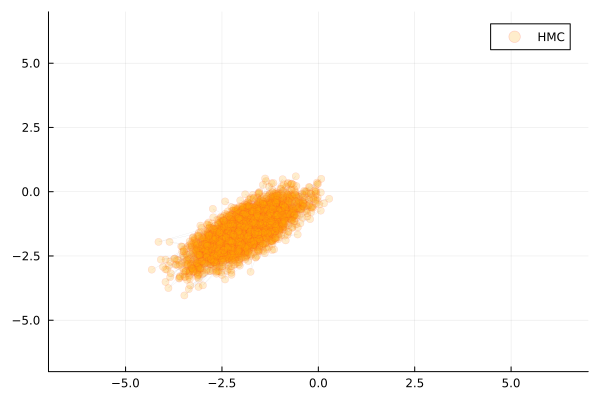

In [39]:
@time s1, a1 = mcmc(
    DualAverage(λ=30.5, δ=0.6),
    HMC(),
    model; n=4e3, n_burn=1e3
)
x_50_hmc = s1[a1, :]
chain_50_hmc = Chains(x_50_hmc)
plt50_hmc = scatterplot(x_50_hmc[:, 1:2], label="HMC", lim=(-7, 7))

Progress: 100%|█████████████████████████████████████████| Time: 0:30:11
  RAHMC(0.02480496387397467, 3628, 0.09665581026937167, Any[]):  0.672831792051987


Acceptance Ratio = 0.6728
1811.818556 seconds (4.18 G allocations: 1.679 TiB, 6.98% gc time, 0.05% compilation time)


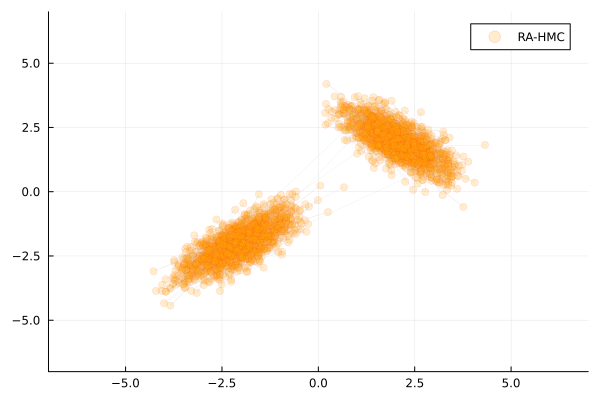

In [40]:
@time s2, a2 = mcmc(
    DualAverage(λ=90.0, δ=0.65),
    RAHMC(),
    model; n=4e3, n_burn=1e3
)
x_50_rahmc = s2[a2, :]
chain_50_rahmc = Chains(x_50_rahmc)
plt50_rahmc = scatterplot(x_50_rahmc[:, 1:2], label="RA-HMC", lim=(-7, 7))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  RAM(ZeroMeanIsoNormal(
dim: 50
μ: Zeros(50)
Σ: [0.0121 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0121 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0121 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0121 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0121 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

Acceptance Ratio = 0.2901
  1.643215 seconds (3.56 M allocations: 501.786 MiB, 61.48% compilation time)


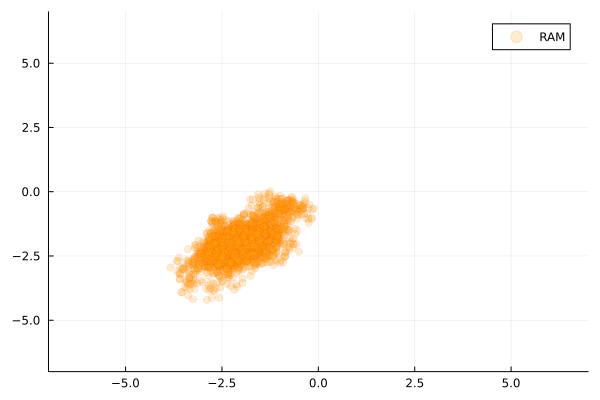

In [41]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 0.11), z=randn(model.d)),
    model; n=1e4, n_burn=1e3
)
x_50_ram = s3[a3, :]
chain_50_ram = Chains(x_50_ram)
plt50_ram = scatterplot(x_50_ram[:, 1:2], lim=(-7, 7), label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54
  PEHMC:  0.9006622516556292


Acceptance Ratio = 0.8846
 54.807333 seconds (122.01 M allocations: 87.459 GiB, 7.50% gc time, 11.43% compilation time)


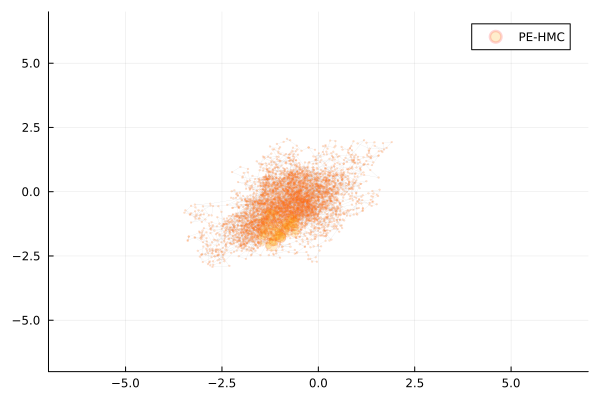

In [42]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.012, L=15, N=100),
    model; n=5e1, n_burn=1e2
)
x_50_pehmc, w_50_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_50_pehmc = Chains(x_50_pehmc)
plt50_pehmc = scatterplot((x_50_pehmc[:, 1:2], w_50_pehmc), label="PE-HMC", lim=(-7, 7))

In [43]:
xs50d = [x_50_hmc, x_50_rahmc, x_50_ram, (x_50_pehmc, w_50_pehmc)]
chains50d = [chain_50_hmc, chain_50_rahmc, chain_50_ram, chain_50_pehmc];

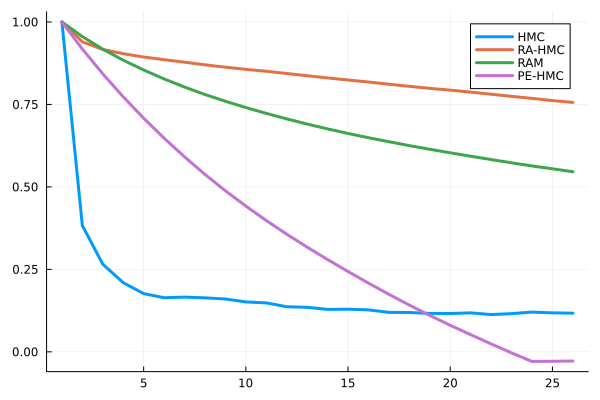

In [44]:
plt50_acf = acfplots(chains50d, names, lw=3)

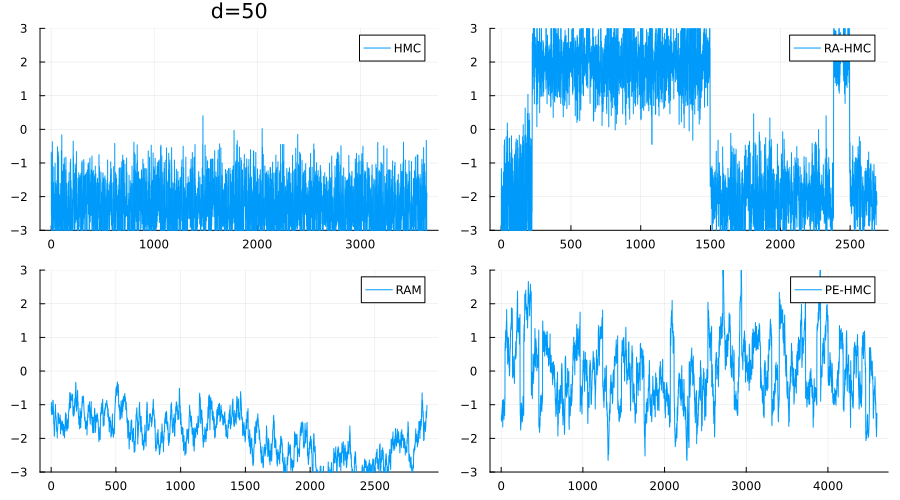

In [45]:
plt50_tr = traceplots(xs50d, names, lw=1, layout=(2,2), ylim=(-3,3), l=100, size=(900, 500), title=["d=$(model.d)" "" "" ""])

In [46]:
mean_ess(chains50d)

4-element Vector{Float64}:
 348.3125402506046
  10.960165552843556
  14.508514501242846
 126.44620643400347

In [47]:
w2.(xs50d)

4-element Vector{Float64}:
 13.106177129401704
  1.9875235600005612
 13.497368606695634
 12.413496661091543

<br><br><br>

---

# Example: $\mathbb R^{100}$

In [48]:
model = generate_model(d=100, s=0.2);

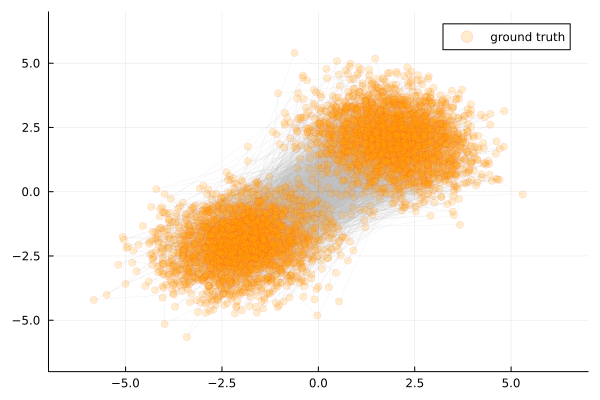

In [49]:
@pipe rand(model.ξ, 5000)[1:2, :]' |> m2t |> scatterplot(_, label="ground truth", lim=(-7, 7))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:30
  HMC(0.1262169151110747, 242, Any[]):  0.975512243878061


Acceptance Ratio = 0.9755
 90.440182 seconds (118.03 M allocations: 121.328 GiB, 9.96% gc time, 22.93% compilation time: 0% of which was recompilation)


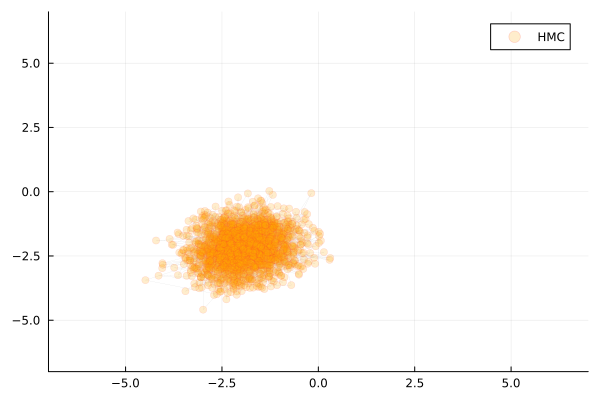

In [50]:
@time s1, a1 = mcmc(
    DualAverage(λ=30.5, δ=0.6),
    HMC(),
    model; n=2e3, n_burn=1e3
)
x_100_hmc = s1[a1, :]
chain_100_hmc = Chains(x_100_hmc)
plt100_hmc = scatterplot(x_100_hmc[:, 1:2], label="HMC", lim=(-7, 7))

Progress: 100%|█████████████████████████████████████████| Time: 0:32:57
  RAHMC(0.014702033166076172, 5441, 0.08125810051443795, Any[]):  0.7141429285357321


Acceptance Ratio = 0.7141
1978.012188 seconds (3.23 G allocations: 4.180 TiB, 10.85% gc time, 0.05% compilation time)


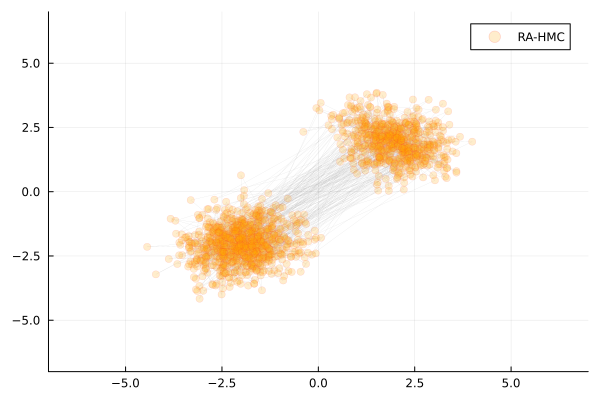

In [51]:
@time s2, a2 = mcmc(
    DualAverage(λ=80.0, δ=0.6),
    RAHMC(),
    model; n=2e3, n_burn=1e3
)
x_100_rahmc = s2[a2, :]
chain_100_rahmc = Chains(x_100_rahmc)
plt100_rahmc = scatterplot(x_100_rahmc[:, 1:2], label="RA-HMC", lim=(-7, 7))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  RAM(ZeroMeanIsoNormal(
dim: 100
μ: Zeros(100)
Σ: [0.005625 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.005625 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.005625 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

Acceptance Ratio = 0.5058
  1.708952 seconds (2.67 M allocations: 398.805 MiB, 6.61% gc time, 62.45% compilation time)


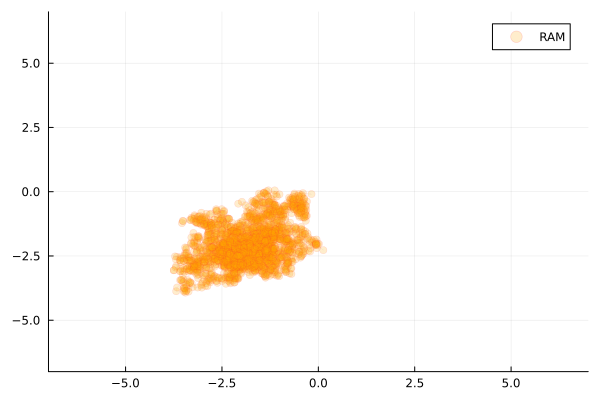

In [52]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 0.075), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_100_ram = s3[a3, :]
chain_100_ram = Chains(x_100_ram)
plt100_ram = scatterplot(x_100_ram[:, 1:2], lim=(-7, 7), label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
  PEHMC:  0.6821192052980133


Acceptance Ratio = 0.6923
 78.845357 seconds (88.95 M allocations: 214.056 GiB, 11.32% gc time, 8.21% compilation time)


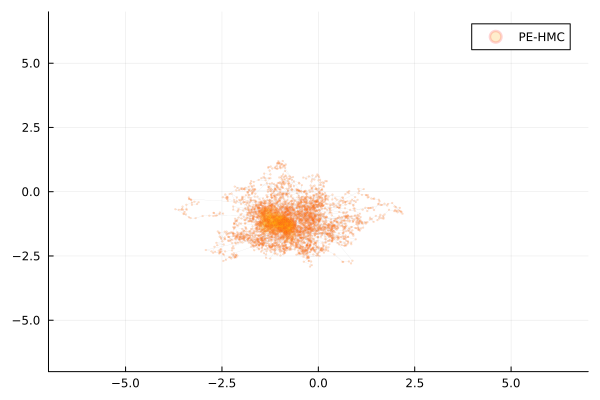

In [53]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.01, L=10, N=100),
    model; n=5e1, n_burn=1e2
)
x_100_pehmc, w_100_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_100_pehmc = Chains(x_100_pehmc)
plt100_pehmc = scatterplot((x_100_pehmc[:, 1:2], w_100_pehmc), label="PE-HMC", lim=(-7, 7))

In [54]:
xs100d = [x_100_hmc, x_100_rahmc, x_100_ram, (x_100_pehmc, w_100_pehmc)]
chains100d = [chain_100_hmc, chain_100_rahmc, chain_100_ram, chain_100_pehmc];

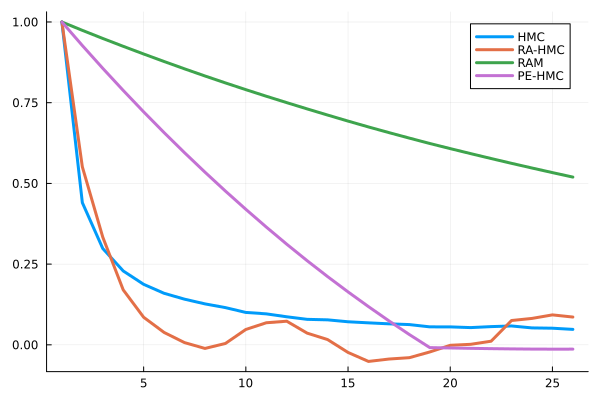

In [55]:
plt100_acf = acfplots(chains100d, names, lw=3, lags=10)

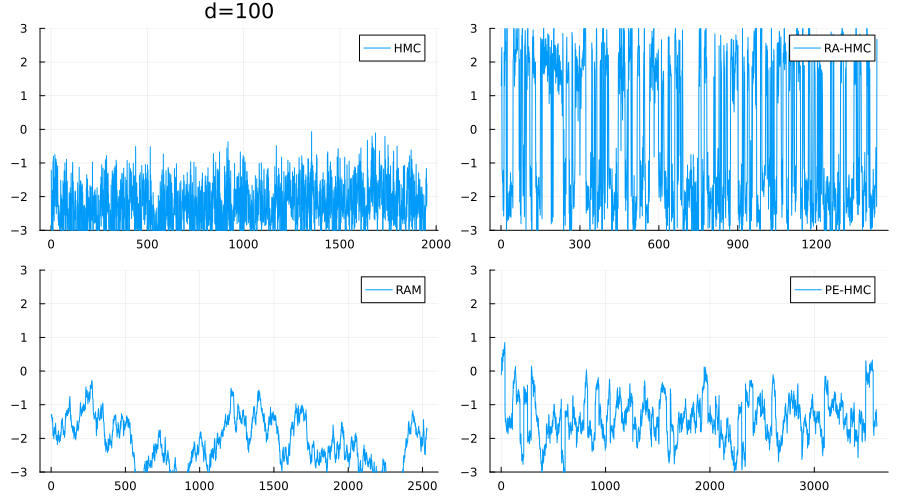

In [56]:
plt100_tr = traceplots(xs100d, names, lw=1, layout=(2,2), ylim=(-3,3), l=100, size=(900, 500), title=["d=$(model.d)" "" "" ""])

In [57]:
mean_ess(chains100d)

4-element Vector{Float64}:
 317.0972275845277
 255.93985926570465
  18.480168571904336
 107.68273896902446

In [58]:
w2.(xs100d)

4-element Vector{Float64}:
 19.557519332332017
  3.495290643008819
 20.209691801521522
 18.832847616551515

---